# Transfer Learning Task
- 쌀 이파리 병에 대한 분류

In [1]:
import os
from glob import glob

root = './datasets/rice/original'

directories = glob(os.path.join(root, '*'))
directory_names = []
for directory in directories:
    directory_names.append(os.path.basename(directory))

print(directory_names)

['Leafsmut', 'Brownspot', 'Bacterialblight']


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

root = './datasets/rice/original'

image_data_generator = ImageDataGenerator(rescale=1./255)

generator = image_data_generator.flow_from_directory(root, target_size=(48, 48), batch_size=32, class_mode='categorical')
print(generator.class_indices)

Found 4684 images belonging to 3 classes.
{'Bacterialblight': 0, 'Brownspot': 1, 'Leafsmut': 2}


In [3]:
import pandas as pd

f_df = pd.DataFrame({'file_paths': generator.filepaths, 'targets': generator.classes})
f_df

,file_paths,targets
0,./datasets/rice/original/Bacterialblight/BACTE...,0
1,./datasets/rice/original/Bacterialblight/BACTE...,0
2,./datasets/rice/original/Bacterialblight/BACTE...,0
3,./datasets/rice/original/Bacterialblight/BACTE...,0
4,./datasets/rice/original/Bacterialblight/BACTE...,0
...,...,...
4679,./datasets/rice/original/Leafsmut/BLAST9_156.jpg,2
4680,./datasets/rice/original/Leafsmut/BLAST9_157.jpg,2
4681,./datasets/rice/original/Leafsmut/BLAST9_158.jpg,2
4682,./datasets/rice/original/Leafsmut/BLAST9_159.jpg,2


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =\
train_test_split(f_df.file_paths, f_df.targets, stratify=f_df.targets, test_size=0.2, random_state=124)

print(y_train.value_counts())
print(y_test.value_counts())

targets
1    1296
0    1283
2    1168
Name: count, dtype: int64
targets
1    324
0    321
2    292
Name: count, dtype: int64


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = \
train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=124)

print(y_train.value_counts())
print(y_val.value_counts())

targets
1    1037
0    1026
2     934
Name: count, dtype: int64
targets
1    259
0    257
2    234
Name: count, dtype: int64


In [6]:
import shutil

root = './datasets/rice/'

for file_path in X_train:
    face_dir = os.path.basename(os.path.dirname(file_path))
    destination = os.path.join(root, 'train', face_dir)

    # # destination 디렉토리가 존재하지 않으면 생성
    if not os.path.exists(destination):
        os.makedirs(destination)

    # # 파일을 destination 디렉토리로 복사
    shutil.copy2(file_path, destination)


In [7]:
import shutil

root = './datasets/rice/'

for file_path in X_val:
    face_dir = os.path.basename(os.path.dirname(file_path))
    destination = os.path.join(root, 'validation', face_dir)

    # # destination 디렉토리가 존재하지 않으면 생성
    if not os.path.exists(destination):
        os.makedirs(destination)

    # # 파일을 destination 디렉토리로 복사
    shutil.copy2(file_path, destination)


In [8]:
import shutil

root = './datasets/rice/'

for file_path in X_test:
    face_dir = os.path.basename(os.path.dirname(file_path))
    destination = os.path.join(root, 'test', face_dir)

    # # destination 디렉토리가 존재하지 않으면 생성
    if not os.path.exists(destination):
        os.makedirs(destination)

    # # 파일을 destination 디렉토리로 복사
    shutil.copy2(file_path, destination)


In [9]:
import albumentations as A

def transform(image):
    aug = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
    ], p=0.2)
    return aug(image=image)['image']

idg = ImageDataGenerator(preprocessing_function=transform, rescale=1./255)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 224

train_dir = './datasets/rice/train/'
validation_dir = './datasets/rice/validation/'
test_dir = './datasets/rice/test/'

train_data_generator = idg
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

# 과적합 발생 시 batch size를 낮추고 과소적합 발생시 batch size를 높인다. 단, 비율에 따라서 조절할 것.
train_generator = train_data_generator.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_data_generator.flow_from_directory(
    validation_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='categorical'
)

print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

Found 2997 images belonging to 3 classes.
Found 750 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
{'Bacterialblight': 0, 'Brownspot': 1, 'Leafsmut': 2}
{'Bacterialblight': 0, 'Brownspot': 1, 'Leafsmut': 2}
{'Bacterialblight': 0, 'Brownspot': 1, 'Leafsmut': 2}


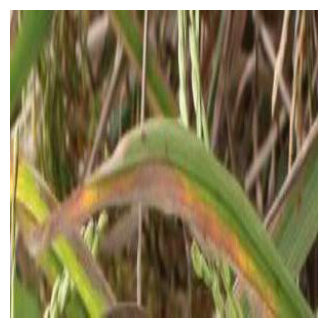

In [11]:
import cv2
import matplotlib.pyplot as plt

image = cv2.cvtColor(cv2.imread(train_generator.filepaths[20]), cv2.COLOR_BGR2RGB)

def show_image(image):
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis('off')

show_image(image)

In [12]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16

model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# 분류기
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(10, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=model.input, outputs=output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         5,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,719,851 (56.15 MB)

 Trainable params: 14,719,851 (56.15 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy

model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['acc'])

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.losses import SparseCategoricalCrossentropy

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min'
)

In [16]:
history = model.fit(train_generator,
                    batch_size=16,
                    epochs=10,
                    validation_data=validation_generator,
                    callbacks=[rlr_cb]
                   )

Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/94 ━━━━━━━━━━━━━━━━━━━━ 8:11 17s/step - acc: 0.3497 - loss: 7.2720

KeyboardInterrupt: 

In [17]:
model.evaluate(test_generator)

30/30 ━━━━━━━━━━━━━━━━━━━━ 111s 4s/step - acc: 0.3554 - loss: 1.0813


[1.0836329460144043, 0.34258270263671875]

In [18]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    
show_history(history)

NameError: name 'history' is not defined

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions

# model = VGG16()
image = load_img('./datasets/hamster.jpeg', target_size=(224, 224))
image = img_to_array(image)
 
image = np.expand_dims(image, axis=0)
prediction = model.predict(image)
target = decode_predictions(prediction)
print(target)
print(target[0][0])
print(target[0][0][1], f'{np.round(target[0][0][2] * 100, 4)}%')